In [1]:
# import required package for data handling
import pandas as pd
import numpy as np

# import required packages for splitting data
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# import required packages for evaluating models
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

# import `logistic regression` model
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# import the packages needed for the Decision Tree
from sklearn.tree import DecisionTreeClassifier  
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

In [3]:
# Loaded in the data
df = pd.read_csv('../csv_files/comp2_raw.csv', index_col=0)
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### Decision Tree ###

In [4]:
# Splitting up our data into variable and target data
X = df.iloc[:, :-1] # Variable
Y = df.Y # Target

In [5]:
# Split dataset into training set and test set
# 70% training and 30% test, random_state = 2019
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=2019)

In [7]:
# import the RandomOverSampler package from imblearn 
from imblearn.over_sampling import RandomOverSampler

# define the model
ros = RandomOverSampler(random_state=2019)

# fit the training data only to the RandomOverSampler model
# this will help address the imbalanced nature of the target variable 
X_train_resample, Y_train_resample = ros.fit_resample(X_train, Y_train)

In [8]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train_resample,Y_train_resample)

# Predict the response for test dataset
Y_pred = clf.predict(X_test)

In [9]:
# Model Accuracy, how often is the Decision Tree correct?
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))

# We are going to look at the classification report and also the confusion matrix for the Decision Tree  
print(metrics.classification_report(Y_test, Y_pred))
print(metrics.confusion_matrix(Y_test, Y_pred))

Accuracy: 0.7301111111111112
              precision    recall  f1-score   support

           0       0.83      0.82      0.83      7063
           1       0.38      0.39      0.39      1937

   micro avg       0.73      0.73      0.73      9000
   macro avg       0.60      0.61      0.61      9000
weighted avg       0.73      0.73      0.73      9000

[[5808 1255]
 [1174  763]]


### Feature Importance ###

In [10]:
# Tao's code 
# define the feature importance variable 
# use the feature importance values from the decision tree above, sort in descending order 
feature_imp = pd.Series(clf.feature_importances_,index=df.iloc[:,:-1].columns).sort_values(ascending=False)

# print the results 
feature_imp

X6     0.176662
X5     0.080028
X12    0.070194
X19    0.067346
X1     0.060896
X18    0.051662
X23    0.050056
X13    0.047992
X20    0.046035
X16    0.045873
X17    0.044236
X15    0.043762
X21    0.042139
X22    0.041077
X14    0.041059
X3     0.017543
X9     0.014781
X4     0.012064
X7     0.010636
X11    0.010155
X8     0.010102
X2     0.008917
X10    0.006786
dtype: float64

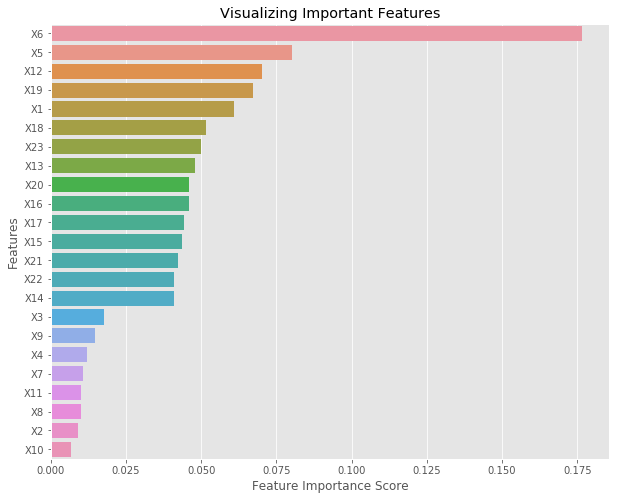

<Figure size 432x288 with 0 Axes>

In [11]:
# Tao's code 
# visualize the feature importance values 
# not required but it helps to reinforce the differences between the features 

#import packages needed for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# define the plot style 
plt.style.use('ggplot')

# define the figure size - makes the readability of the graph better 
plt.figure(figsize=(10,8))

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")

plt.show()
plt.savefig('DT feature importance raw.png')

### Evaluate the Decision Tree ###

In [12]:
# lists for f1-score and AUC
f1_score_lst = []
auc_lst = []


#loop to calculate f1 and auc scores and present averages after 10 runs
for count in range (1,10):
    
    #10-fold cross validation
    kfold = model_selection.KFold(n_splits=10, random_state=2019)
    scoring = 'accuracy'
    results = model_selection.cross_val_score(clf, X_train_resample, Y_train_resample, cv=kfold, scoring=scoring)

    
    #calculate f1-score and AUC
    clf_roc_auc = roc_auc_score(Y_test, Y_pred)
    f1_score_lst.append(precision_recall_fscore_support(Y_test, Y_pred, average='weighted')[2])
    auc_lst.append(clf_roc_auc)


print('F1 {:.4f}; AUC {:.4f} '.format(np.mean(f1_score_lst),np.mean(auc_lst)))

#result=logit_model.fit()
confusion_matrix_y = confusion_matrix(Y_test, Y_pred)


#print(result.summary())
print('Accuracy of classifier on test set: {:.2f}'.format(clf.score(X_test, Y_test)))

print("10-fold cross validation average accuracy of classifier: %.3f" % (results.mean()))

print('Confusion Matrix for Logistic Regression Classfier:')
print(confusion_matrix_y)

print('Classification Report for Logistic Regression Classfier:')
print(classification_report(Y_test, Y_pred))

F1 0.7321; AUC 0.6081 
Accuracy of classifier on test set: 0.73
10-fold cross validation average accuracy of classifier: 0.892
Confusion Matrix for Logistic Regression Classfier:
[[5808 1255]
 [1174  763]]
Classification Report for Logistic Regression Classfier:
              precision    recall  f1-score   support

           0       0.83      0.82      0.83      7063
           1       0.38      0.39      0.39      1937

   micro avg       0.73      0.73      0.73      9000
   macro avg       0.60      0.61      0.61      9000
weighted avg       0.73      0.73      0.73      9000



In [14]:
# commented out for now becaues it takes forever to run and sometimes doesn't run 
# will decide what to do with later 
"""dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())"""

'dot_data = StringIO()\nexport_graphviz(clf, out_file=dot_data,  \n                filled=True, rounded=True,\n                special_characters=True)\ngraph = pydotplus.graph_from_dot_data(dot_data.getvalue())  \nImage(graph.create_png())'

### Pruning the Decision Tree ##

In [15]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=5)

# Train Decision Tree Classifer
clf = clf.fit(X_train_resample,Y_train_resample)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))

# We are going to look at the classification report and also the confusion matrix for our model
print(metrics.classification_report(Y_test, Y_pred))
print(metrics.confusion_matrix(Y_test, Y_pred))

Accuracy: 0.7301111111111112
              precision    recall  f1-score   support

           0       0.83      0.82      0.83      7063
           1       0.38      0.39      0.39      1937

   micro avg       0.73      0.73      0.73      9000
   macro avg       0.60      0.61      0.61      9000
weighted avg       0.73      0.73      0.73      9000

[[5808 1255]
 [1174  763]]


**Suprisingly the pruning of our tree did not make our results better.**

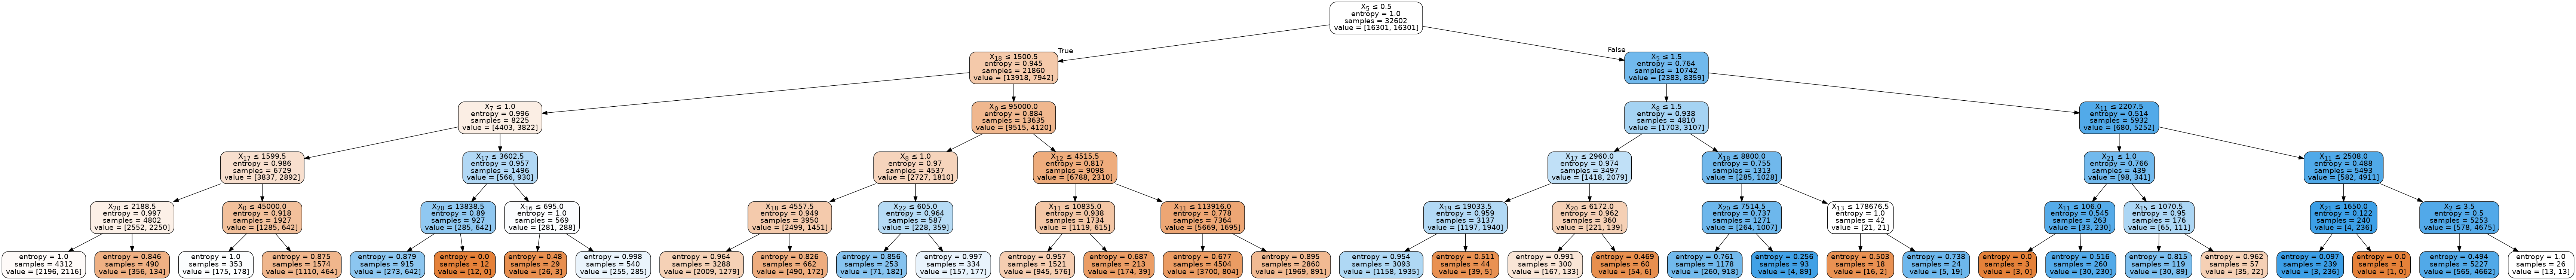

In [16]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Logistic Regression ###

In [18]:
# initiate the logistic regression function 
logreg = LogisticRegression(solver='liblinear')

# pass the training data into the model. This training data includes all of the independent variables 
logreg = logreg.fit(X_train_resample,Y_train_resample) 

# tell the model what to predict, or in this case classify, and what variables to use to predict the dependent variable 
Y_pred=logreg.predict(X_test)

In [19]:
# calculate accuracy, precision and recall measures of the model 
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))
print("Precision:",metrics.precision_score(Y_test, Y_pred))
print('Recall:',metrics.recall_score(Y_test, Y_pred))

Accuracy: 0.5537777777777778
Precision: 0.2860670919942375
Recall: 0.7176045431078988


### Evaluate the Logistic Regression ###

In [20]:
# lists for f1-score and AUC
f1_score_lst = []
auc_lst = []

#loop to calculate f1 and auc scores and present averages after 10 runs
for count in range (1,10):
    
    #10-fold cross validation
    kfold = model_selection.KFold(n_splits=10, random_state=2019)
    scoring = 'accuracy'
    results = model_selection.cross_val_score(logreg, X_train_resample, Y_train_resample, cv=kfold, scoring=scoring)

    #calculate f1-score and AUC
    clf_roc_auc = roc_auc_score(Y_test, Y_pred)
    f1_score_lst.append(precision_recall_fscore_support(Y_test, Y_pred, average='weighted')[2])
    auc_lst.append(clf_roc_auc)


print('F1 {:.4f}; AUC {:.4f} '.format(np.mean(f1_score_lst),np.mean(auc_lst)))

#result=logit_model.fit()
confusion_matrix_y = confusion_matrix(Y_test, Y_pred)


#print(result.summary())
print('Accuracy of classifier on test set: {:.2f}'.format(logreg.score(X_test, Y_test)))

print("10-fold cross validation average accuracy of classifier: %.3f" % (results.mean()))

print('Confusion Matrix for Logistic Regression Classfier:')
print(confusion_matrix_y)

print('Classification Report for Logistic Regression Classfier:')
print(classification_report(Y_test, Y_pred))

F1 0.5915; AUC 0.6132 
Accuracy of classifier on test set: 0.55
10-fold cross validation average accuracy of classifier: 0.573
Confusion Matrix for Logistic Regression Classfier:
[[3594 3469]
 [ 547 1390]]
Classification Report for Logistic Regression Classfier:
              precision    recall  f1-score   support

           0       0.87      0.51      0.64      7063
           1       0.29      0.72      0.41      1937

   micro avg       0.55      0.55      0.55      9000
   macro avg       0.58      0.61      0.53      9000
weighted avg       0.74      0.55      0.59      9000



In [21]:
# feature extraction using Logistic Regression & RFE 
# this takes a while to run 

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

for i in range(1, (df.shape[1] + 1 )):
    print(i)
    # create a base classifier used to evaluate a subset of attributes
    model = LogisticRegression()
    # create the RFE model and select 3 attributes
    rfe = RFE(model, i)
    rfe = rfe.fit(X, Y)
    # summarize the selection of the attributes
    print('Model with the best', i, 'features')
    print(dict(zip(df.columns, rfe.ranking_)))

1
Model with the best 1 features
{'X1': 19, 'X2': 4, 'X3': 6, 'X4': 3, 'X5': 9, 'X6': 1, 'X7': 5, 'X8': 2, 'X9': 8, 'X10': 7, 'X11': 10, 'X12': 15, 'X13': 16, 'X14': 21, 'X15': 23, 'X16': 18, 'X17': 22, 'X18': 11, 'X19': 12, 'X20': 14, 'X21': 13, 'X22': 17, 'X23': 20}
2
Model with the best 2 features
{'X1': 18, 'X2': 3, 'X3': 5, 'X4': 2, 'X5': 8, 'X6': 1, 'X7': 4, 'X8': 1, 'X9': 7, 'X10': 6, 'X11': 9, 'X12': 14, 'X13': 15, 'X14': 20, 'X15': 22, 'X16': 17, 'X17': 21, 'X18': 10, 'X19': 11, 'X20': 13, 'X21': 12, 'X22': 16, 'X23': 19}
3
Model with the best 3 features
{'X1': 17, 'X2': 2, 'X3': 4, 'X4': 1, 'X5': 7, 'X6': 1, 'X7': 3, 'X8': 1, 'X9': 6, 'X10': 5, 'X11': 8, 'X12': 13, 'X13': 14, 'X14': 19, 'X15': 21, 'X16': 16, 'X17': 20, 'X18': 9, 'X19': 10, 'X20': 12, 'X21': 11, 'X22': 15, 'X23': 18}
4
Model with the best 4 features
{'X1': 16, 'X2': 1, 'X3': 3, 'X4': 1, 'X5': 6, 'X6': 1, 'X7': 2, 'X8': 1, 'X9': 5, 'X10': 4, 'X11': 7, 'X12': 12, 'X13': 13, 'X14': 18, 'X15': 20, 'X16': 15, 'X17'